In [1]:
import glob
import numpy as np
import pandas as pd
import pickle as pkl


import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [2]:
samples_dir = "/Users/cmantill/CMS/HWW/boostedhiggs/binder/testWJets_inference_genmass_2017"
samples = ["WJetsToLNu_HT-100To200","WJetsToLNu_HT-1200To2500","WJetsToLNu_HT-200To400",
           "WJetsToLNu_HT-2500ToInf","WJetsToLNu_HT-400To600","WJetsToLNu_HT-600To800",
           "WJetsToLNu_HT-70To100","WJetsToLNu_HT-800To1200"]

ch = "mu"

parquet_files = []
for sample in samples:
    out_files = f"{samples_dir}/{sample}/outfiles/"
    parquet_files.extend(glob.glob(f"{out_files}/*_{ch}.parquet"))

data = pd.read_parquet(parquet_files)
data = data.fillna(-1)

In [8]:
data.columns.to_numpy()

array(['fj_pt', 'fj_msoftdrop', 'fj_msoftdrop_nocorr', 'fj_mass',
       'fj_lsf3', 'fj_sj1_pt', 'fj_sj2_pt', 'fj_tau3', 'fj_tau2',
       'fj_bjets_ophem', 'fj_bjets', 'lep_pt', 'lep_isolation',
       'lep_misolation', 'fj_minus_lep_m', 'fj_minus_lep_pt',
       'dphi_lep_and_fj_minus_lep', 'lep_fj_dr', 'lep_met_mt',
       'met_fj_dphi', 'rec_higgs_m', 'rec_higgs_pt', 'rec_W_lnu_m',
       'rec_W_lnu_pt', 'rec_W_qq_m', 'rec_W_qq_pt', 'rec_dphi_WW',
       'lep_mvaId', 'mu_highPtId', 'ele_highPtId', 'met', 'ht', 'nfj',
       'nj', 'deta', 'mjj', 'n_bjets_L', 'n_bjets_M', 'n_bjets_T',
       'n_bjets_ophem_L', 'n_bjets_ophem_M', 'n_bjets_ophem_T', 'mreg',
       'fj_nprongs', 'fj_lepinprongs', 'fj_ncquarks', 'fj_V_isMatched',
       'fj_V_2q', 'fj_V_elenu', 'fj_V_munu', 'fj_V_taunu',
       'fj_genjetmass', 'weight', 'weight_genweight',
       'weight_L1Prefiring', 'weight_pileup', 'weight_trigger_iso_muon',
       'weight_trigger_noniso_muon', 'weight_isolation_muon',
       'weight

In [9]:
# add score

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1)
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num / den

sigs = ["fj_ParT_probHWqqWmv0c", "fj_ParT_probHWqqWmv1c", "fj_ParT_probHWqqWtaumv0c", "fj_ParT_probHWqqWtaumv1c",
        "fj_ParT_probHWqqWev0c", "fj_ParT_probHWqqWev1c", "fj_ParT_probHWqqWtauev0c", "fj_ParT_probHWqqWtauev1c",
        "fj_ParT_probHWqqWqq0c", "fj_ParT_probHWqqWqq1c", "fj_ParT_probHWqqWqq2c",
        "fj_ParT_probHWqqWq0c", "fj_ParT_probHWqqWq1c", "fj_ParT_probHWqqWq2c",    
       ]

qcd = ["fj_ParT_probQCDbb", "fj_ParT_probQCDcc", "fj_ParT_probQCDb", "fj_ParT_probQCDc", "fj_ParT_probQCDothers"]
tope = ["fj_ParT_probTopbWev", "fj_ParT_probTopbWtauev"]
topm = ["fj_ParT_probTopbWmv", "fj_ParT_probTopbWtaumv"]
tophad = ["fj_ParT_probTopbWqq0c", "fj_ParT_probTopbWqq1c", "fj_ParT_probTopbWq0c", 
          "fj_ParT_probTopbWq1c", "fj_ParT_probTopbWtauhv"]

inclusive_bkg = [b for b in qcd + tope + topm + tophad]

data["inclusive_score"] = disc_score(data, sigs, inclusive_bkg)
data["top_score"] = disc_score(data, sigs, tope+topm+tophad)

In [4]:
data["all_true"] = (data.fj_V_isMatched.astype(int) >= 0)
labels = {
    "label_W_mv": "((fj_V_isMatched == 1 & fj_nprongs>0 & fj_lepinprongs==1))",
    "label_W_nomu": "((fj_V_isMatched == 1 & fj_nprongs>0 & fj_lepinprongs==0))",
    "label_W_noprongs": "((fj_V_isMatched == 1 & fj_nprongs==0 & fj_lepinprongs==0))",
    "label_W_unmatched": "((fj_V_isMatched == 0))",
}
for l,ldef in labels.items():
    data[l] = data.query(ldef)["all_true"]
    data[l] = data[l].fillna(0)
    data[l] = data[l].astype(int)
    
data["ptlnu_ptqq"] = data.rec_W_lnu_pt/data.rec_W_qq_pt

In [5]:
np.sum(data["all_true"])

1917953

In [6]:
np.sum(data["label_W_nomu"])

0

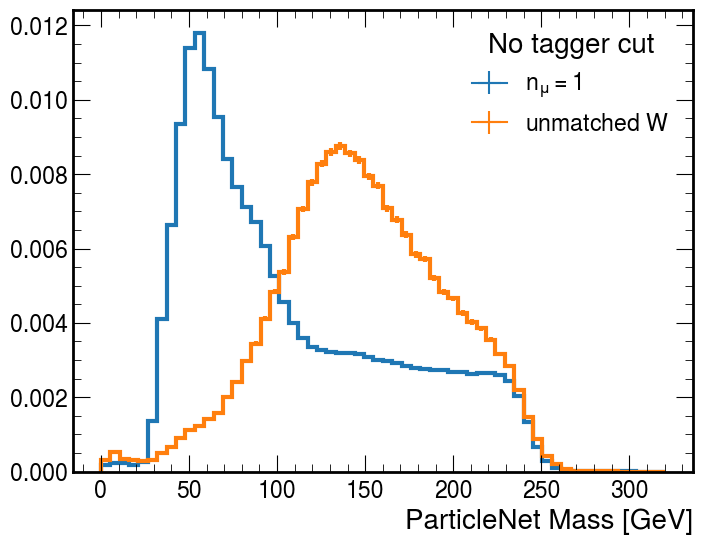

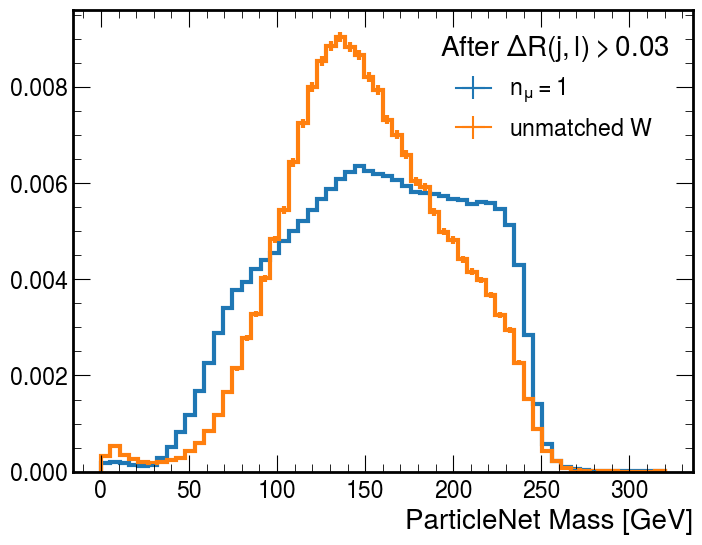

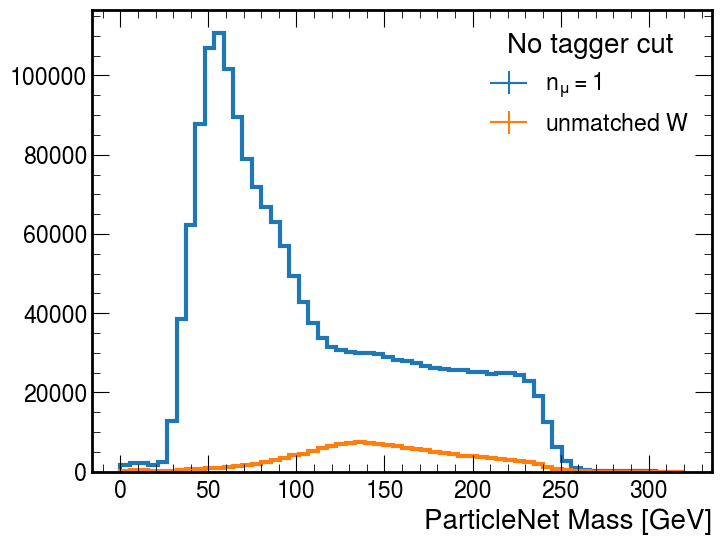

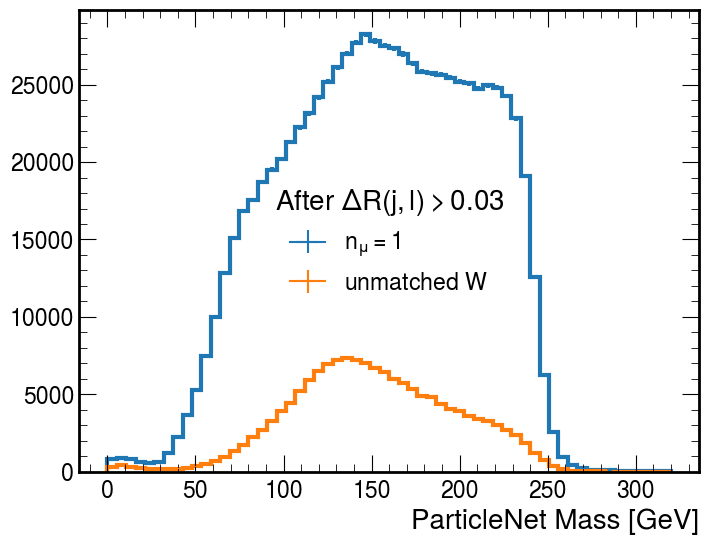

In [21]:
tagger_cut = 0.9
tagger_selection = data.inclusive_score > tagger_cut

sel = (data.lep_fj_dr > 0.03)
#sel = data.ptlnu_ptqq < 4.8

#sel = sel & tagger_selection

h = hist2.Hist(
    #hist2.axis.Regular(40, 20, 250, name="mass", label=r"Jet $m_{SD}$ [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParT Mass [GeV]", overflow=True),
    hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParticleNet Mass [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="gmass", label=r"Gen Jet Mass [GeV]", overflow=True),
    hist2.axis.Boolean(name="mv"),
    hist2.axis.Boolean(name="nomu"),
    hist2.axis.Boolean(name="noprongs"),
    hist2.axis.Boolean(name="unmatched"),
)

h.fill(
    #mass=data.fj_msoftdrop,
    #gmass=data.fj_genjetmass,
    #mass=data.fj_ParT_mass,
    mass=data.fj_ParticleNet_mass,
    mv=data.label_W_mv,
    nomu=data.label_W_nomu,
    noprongs=data.label_W_noprongs,
    unmatched=data.label_W_unmatched
)

h_sel = hist2.Hist(
    #hist2.axis.Regular(40, 20, 250, name="mass", label=r"Jet $m_{SD}$ [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParT Mass [GeV]", overflow=True),
    hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParticleNet Mass [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="gmass", label=r"Gen Jet Mass [GeV]", overflow=True),
    hist2.axis.Boolean(name="mv"),
    hist2.axis.Boolean(name="nomu"),
    hist2.axis.Boolean(name="noprongs"),
    hist2.axis.Boolean(name="unmatched"),
)
h_sel.fill(
    #mass=data[sel].fj_msoftdrop,
    #gmass=data[sel].fj_genjetmass,
    mass=data[sel].fj_ParticleNet_mass,
    #mass=data[sel].fj_ParT_mass,
    mv=data[sel].label_W_mv,
    nomu=data[sel].label_W_nomu,
    noprongs=data[sel].label_W_noprongs,
    unmatched=data[sel].label_W_unmatched
)

legends = {
    "label_W_mv": r"$n_\mu=1$",
    "label_W_nomu": r"$n_\mu=0$, $n_q>0$",
    "label_W_noprongs": r"$n_q=0$ soft-radiation",
    "label_W_unmatched": r"unmatched $W$",
}

label_W_mv = {"mv":1, "nomu":sum, "noprongs":sum, "unmatched": sum}
label_W_nomu = {"mv":sum, "nomu":1, "noprongs":sum, "unmatched": sum}
label_W_noprongs = {"mv":sum, "nomu":sum, "noprongs":1, "unmatched": sum}
label_W_unmatched = {"mv":sum, "nomu":sum, "noprongs":sum, "unmatched": 1}
  
for den in [True,False]:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.histplot(
        h[label_W_mv],ax=ax,label=legends["label_W_mv"],linewidth=3,density=den
    )
    #hep.histplot(
    #    h[label_W_noprongs],ax=ax,label=legends["label_W_noprongs"],linewidth=3,density=den,
    #)
    hep.histplot(
        h[label_W_unmatched],ax=ax,label=legends["label_W_unmatched"],linewidth=3,density=den,
    )
    ax.legend(title="No tagger cut")
    #ax.legend(title="Tagger cut > 0.9")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.histplot(
        h_sel[label_W_mv],ax=ax,label=legends["label_W_mv"],linewidth=3,density=den
    )
    hep.histplot(
        h_sel[label_W_unmatched],ax=ax,label=legends["label_W_unmatched"],linewidth=3,density=den,
    )
    ax.legend(title=r"After $\Delta R(j,l)>0.03$")
    #ax.legend(title=r"After $p_T^{\ell\nu}/p_T^{qq}<4.8$")
    #ax.legend(title=r"Tagger cut > 0.9, $p_T^{\ell\nu}/p_T^{qq}<4.8$")    
    #ax.legend(title=r"Tagger cut > 0.9, $\Delta R(j,l)>0.03$")
    
    